# Лабораторная работа №5

*Арешин Станислав Олегович М8О-211M-21*

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
warnings.filterwarnings("ignore")

%matplotlib inline

# Предобработка данных

In [2]:
df = pd.read_csv('games.csv')
print(df.shape)
df.head()

(16715, 11)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем колонки к нижнему регистру

In [3]:
df.rename(columns={name : name.lower() for name in df.columns}, inplace=True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Пропущенные значения

Год надо бы привести к инту, есть пропущенные значения, давайте разбираться

### critic_score

оценка критиков (максимум 100). Вряд ли игра не оценивалась критиками, но пропущенное значение есть пропущенное значение. Медианой заполнять не хочется, так как почти половина данных с пропусками, можно сильно испортить распределение и затем сделать неверные выводы, поэтому я пока заполню через -1, будем держать в голове что это пропуск, далее все равно скорее всего придется отсекать данные по времени и уже на итоговой выборке может получится придумать решение получше.

In [5]:
df['critic_score'].min(), df['critic_score'].max(), df['critic_score'].median()

(13.0, 98.0, 71.0)

In [6]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [7]:
df['critic_score'] = df['critic_score'].fillna(-1)

### user_score

оценка пользователей (максимум 10). Значение tbd (to be determined) обычно означает подлежит уточнению, то есть скорее всего игра еще не оценена. Кажется, это можно также считать обычным пропущенным значением. Посмотрим чуть подробнее, что из себя представляют такие игры

In [8]:
print('Медиана продаж по всем данным без игр с оценкой tbd:')
print('NA: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['na_sales'].median())
print('EU: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['eu_sales'].median())
print('JP: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['jp_sales'].median())
print('OTHER: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['other_sales'].median())
print()
print('NA: ', df[df['user_score'] == 'tbd']['na_sales'].median())
print('EU: ', df[df['user_score'] == 'tbd']['eu_sales'].median())
print('JP: ', df[df['user_score'] == 'tbd']['jp_sales'].median())
print('OTHER: ', df[df['user_score'] == 'tbd']['other_sales'].median())

Медиана продаж по всем данным без игр с оценкой tbd:
NA:  0.14
EU:  0.06
JP:  0.0
OTHER:  0.02

NA:  0.07500000000000001
EU:  0.01
JP:  0.0
OTHER:  0.01


In [9]:
print('Медиана продаж по всем данным без игр с оценкой tbd:')
print('NA: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['na_sales'].mean())
print('EU: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['eu_sales'].mean())
print('JP: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['jp_sales'].mean())
print('OTHER: ', df[(df['user_score'] != 'tbd') & (~df['user_score'].isna())]['other_sales'].mean())
print()
print('NA: ', df[df['user_score'] == 'tbd']['na_sales'].mean())
print('EU: ', df[df['user_score'] == 'tbd']['eu_sales'].mean())
print('JP: ', df[df['user_score'] == 'tbd']['jp_sales'].mean())
print('OTHER: ', df[df['user_score'] == 'tbd']['other_sales'].mean())

Медиана продаж по всем данным без игр с оценкой tbd:
NA:  0.3758155467720872
EU:  0.22489328063239783
JP:  0.05909222661396478
OTHER:  0.07938866930170389

NA:  0.12605198019801728
EU:  0.04351897689769022
JP:  0.0027268976897689744
OTHER:  0.015862211221121834


Судя по всему игры с оценкой tbd менее успешные, чем оцененные, однако, не неастолько, чтобы их просто исключить 

In [10]:
df[df['user_score'] == 'tbd']['year_of_release'].unique()

array([2010., 2005., 2011.,   nan, 2009., 2004., 1999., 2001., 2008.,
       2007., 2003., 2000., 2006., 2002., 2015., 2014., 2012., 2013.,
       2016., 1997.])

И нет такого, чтобы не оцененные игры были слишком старыми. Давайте tbd пока заполним -2, а обычные наны -1, а также переведем столбец в формат float

In [11]:
df['user_score'] = df['user_score'].map({'tbd' : -2})
df['user_score'] = df['user_score'].fillna(-1)
df['user_score'] = df['user_score'].astype('float32')

### rating  

Рейтинг от организации ESRB. Довольно много нанов, их надо либо не заполнять, либо заполнить по умному. Я бы заполнил как самый частый рейтинг по жанру игры. Напишем для этого небольшую функцию

In [12]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [13]:
from collections import Counter

def fill_ratings(df):
    df_res = df.copy()
    new_ratings = []
    for i in range(len(df_res)):
        if (df_res.iloc[i]['rating'] != df_res.iloc[i]['rating']) and (df_res.iloc[i]['genre'] == df_res.iloc[i]['genre']):
            genre = df_res.iloc[i]['genre']
            most_freq = Counter(df_res[(df_res['genre'] == genre) & (~df_res['rating'].isna())]['rating'])\
                                .most_common(1)
            new_ratings.append(most_freq[0][0])
        else:
            new_ratings.append(df_res.iloc[i]['rating'])
    df_res['rating'] = new_ratings
    return df_res

In [14]:
df = fill_ratings(df)

### Остатки

Окей, осталось 2 игры с незаполненными именем, рейтингом и жанром, их просто исключаем. Также где-то 260 игр без года релиза, тоже исключаем, не велика потеря

In [15]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float32
 10  rating           16444 non-null  object 
dtypes: float32(1), float64(6), object(4)
memory usage: 1.4+ MB


И также приводим год к инту

In [16]:
df['year_of_release'] = df['year_of_release'].astype('int64')

## Суммарные продажи

In [17]:
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# EDA

## Распределение игр по годам

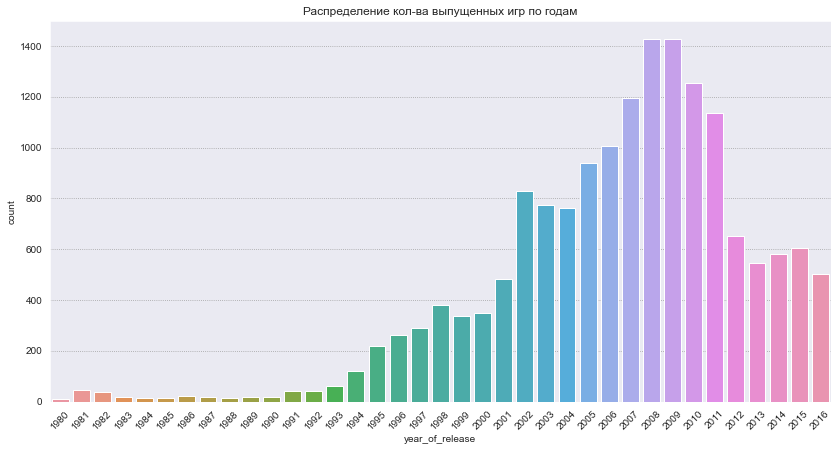

In [18]:
plt.figure(figsize=(14,7))
plt.title('Распределение кол-ва выпущенных игр по годам')
sns.countplot(df['year_of_release'])
plt.xticks(rotation=45)
plt.show()

Видно, что старые данные точно нет смысла использовать. Также есть смысл убрать пик в 2010х, чтобы информация была более актуальной. Мы хотим строить прогноз на 2017, поэтому логично оставить данные, которые плюс минус похожи на то, что было до этого, то есть берем предыдущий год - 2016 и также 2011, 2012, 2013, 2014, 2015, так как их распределение по выпуску игр в год почти совпадает. Теперь посмотрим на то, сколько живут платформы и может нужно будет еще что-то отсечь (например в 2011 и 2012 вроде еще жива была ps2, а в 2016 уже точно нет)

## Популярные платформы и их жизнь

Возьмем топ 5 самых популярных платформ и посчитаем, как выпуск игр под эти платформы распределен по годам

In [19]:
most_popular = [el[0] for el in Counter(df['platform']).most_common(10)]
most_popular

['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PSP', 'PS', 'PC', 'GBA', 'XB']

In [20]:
df_tmp = df[df['platform'].isin(most_popular)].copy()
df_tmp.shape

(13026, 12)

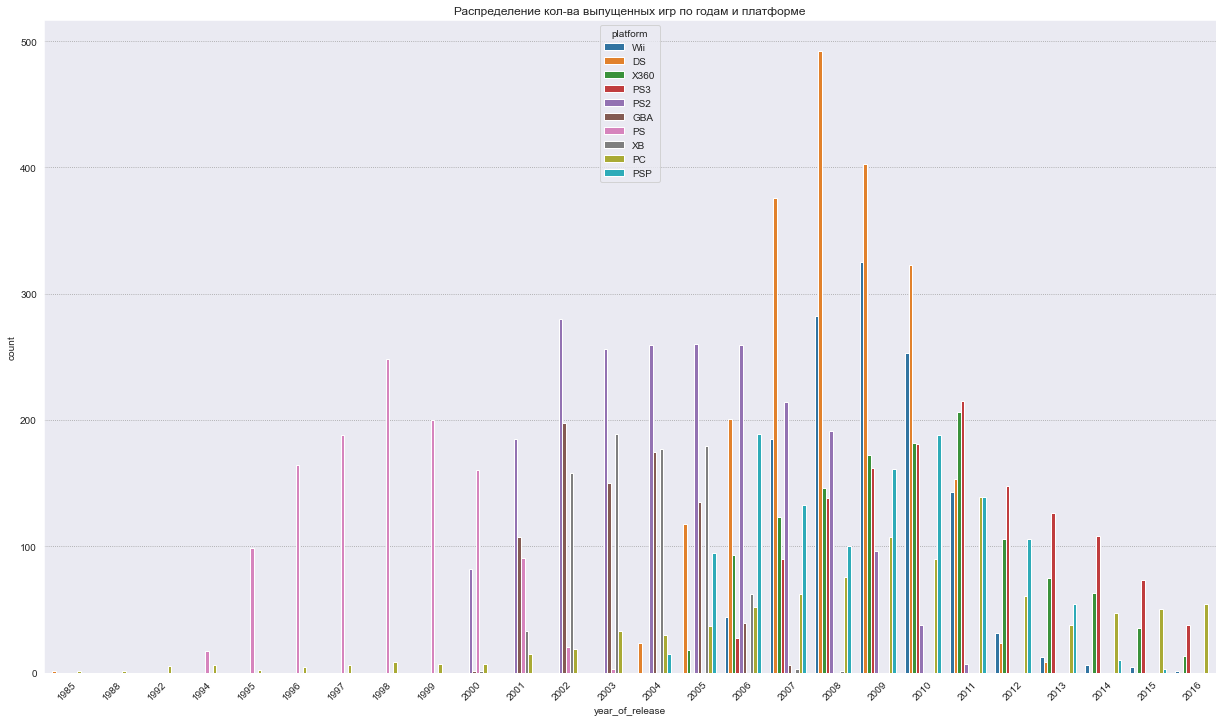

In [21]:
plt.figure(figsize=(21,12))
plt.title('Распределение кол-ва выпущенных игр по годам и платформе')
sns.countplot(x=df_tmp['year_of_release'], hue = df_tmp['platform'])
plt.xticks(rotation=45)
plt.show()

Платформы живут примерно по 9 лет, ps1, ps2 очевидно уже умерли к 2016 году, на PC игры выходят стабильно (он бессмертен). PS3 и XBOX360 начинают появляться в 2006. По итогу мы видим , что к 2015-2016 году "на ходу" из всех популярных платформ за все время остаются ps3, pc, xbox 360. Очевидно, что уже релизнулась ps4 и новый x ящик, а мы их не видим, поэтому давайте обрежем датой выхода консолей этого поколения - 2013 и посмотрим, что происходит

In [22]:
df_tmp = df[df['year_of_release'] >= 2013].copy()
df_tmp.shape

(2233, 12)

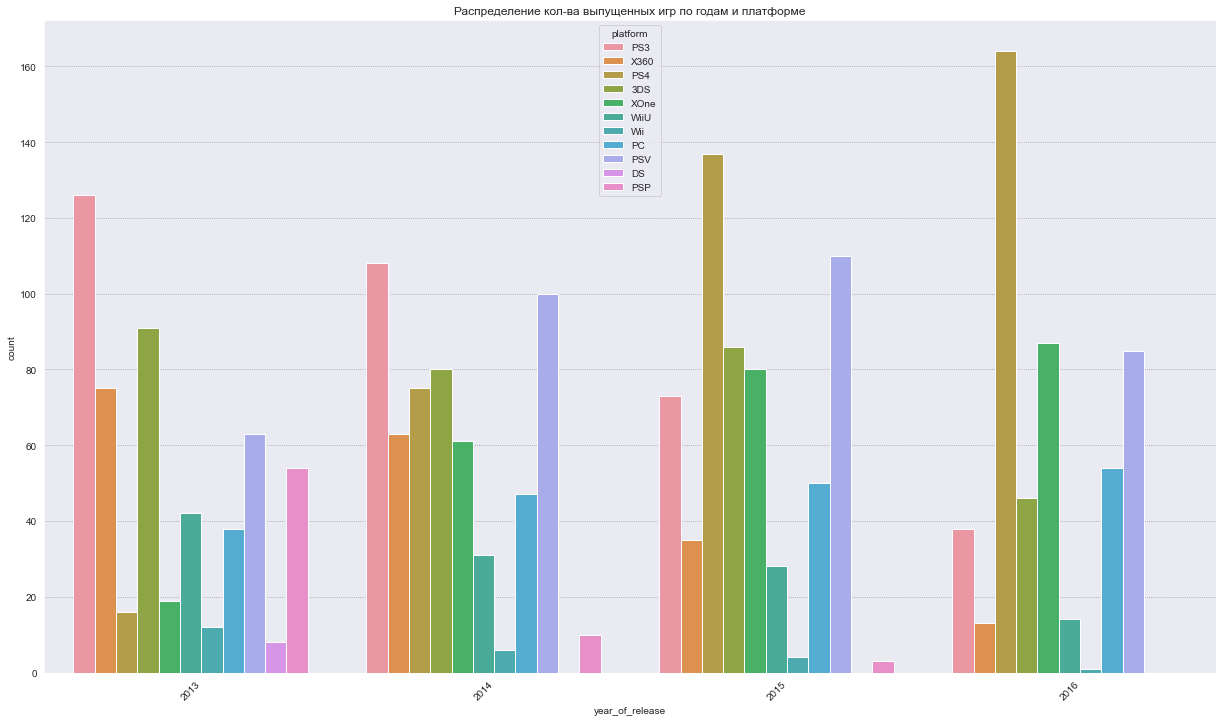

In [23]:
plt.figure(figsize=(21,12))
plt.title('Распределение кол-ва выпущенных игр по годам и платформе')
sns.countplot(x=df_tmp['year_of_release'], hue = df_tmp['platform'])
plt.xticks(rotation=45)
plt.show()

Супер. Что мы видим? PSP c 2014 года умирает, в 2016 ее уже вообще нет. Доля PS3 и Xbox360 уменьшается, вперед выходят PS4 и Xbox One. PSV стабильно, PC тоже. Wii, Wiiu тоже стабильно.

По итогу на 2016 год лидирует с большим отрывом PS4, далее XOne и PC. Самые три платформы, которые всего на слуху - платформа от Sony, от Microsoft и старый добрый PC, меняются со временем только версии этих консолей.

Итак, я предлагаю взять данные 2015, 2016 года (обычно 2 года горизонт это нормально для прогноза) и взять только актуальные платформы (нет смысла брать ps3 и xbox360, так как все то же самое выйдет на ps4 и xbox one и даже больше). Берем платформы PS4, Xbox One, PC, PSV, 3DS.


In [24]:
platforms = ['PS4', 'XOne', 'PC', 'PSV', '3DS']
df_new = df[df['year_of_release'] >= 2015].copy()
df_new = df_new[df_new['platform'].isin(platforms)]
print(df_new.shape)
df_new.head()

(899, 12)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,M,14.63
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,-1.0,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,M,7.98
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,-1.0,E,7.60
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,-1.0,-1.0,M,7.39


## Ящик с усами

In [25]:
platforms = ['PS4', 'XOne', 'PC', 'PSV', '3DS']

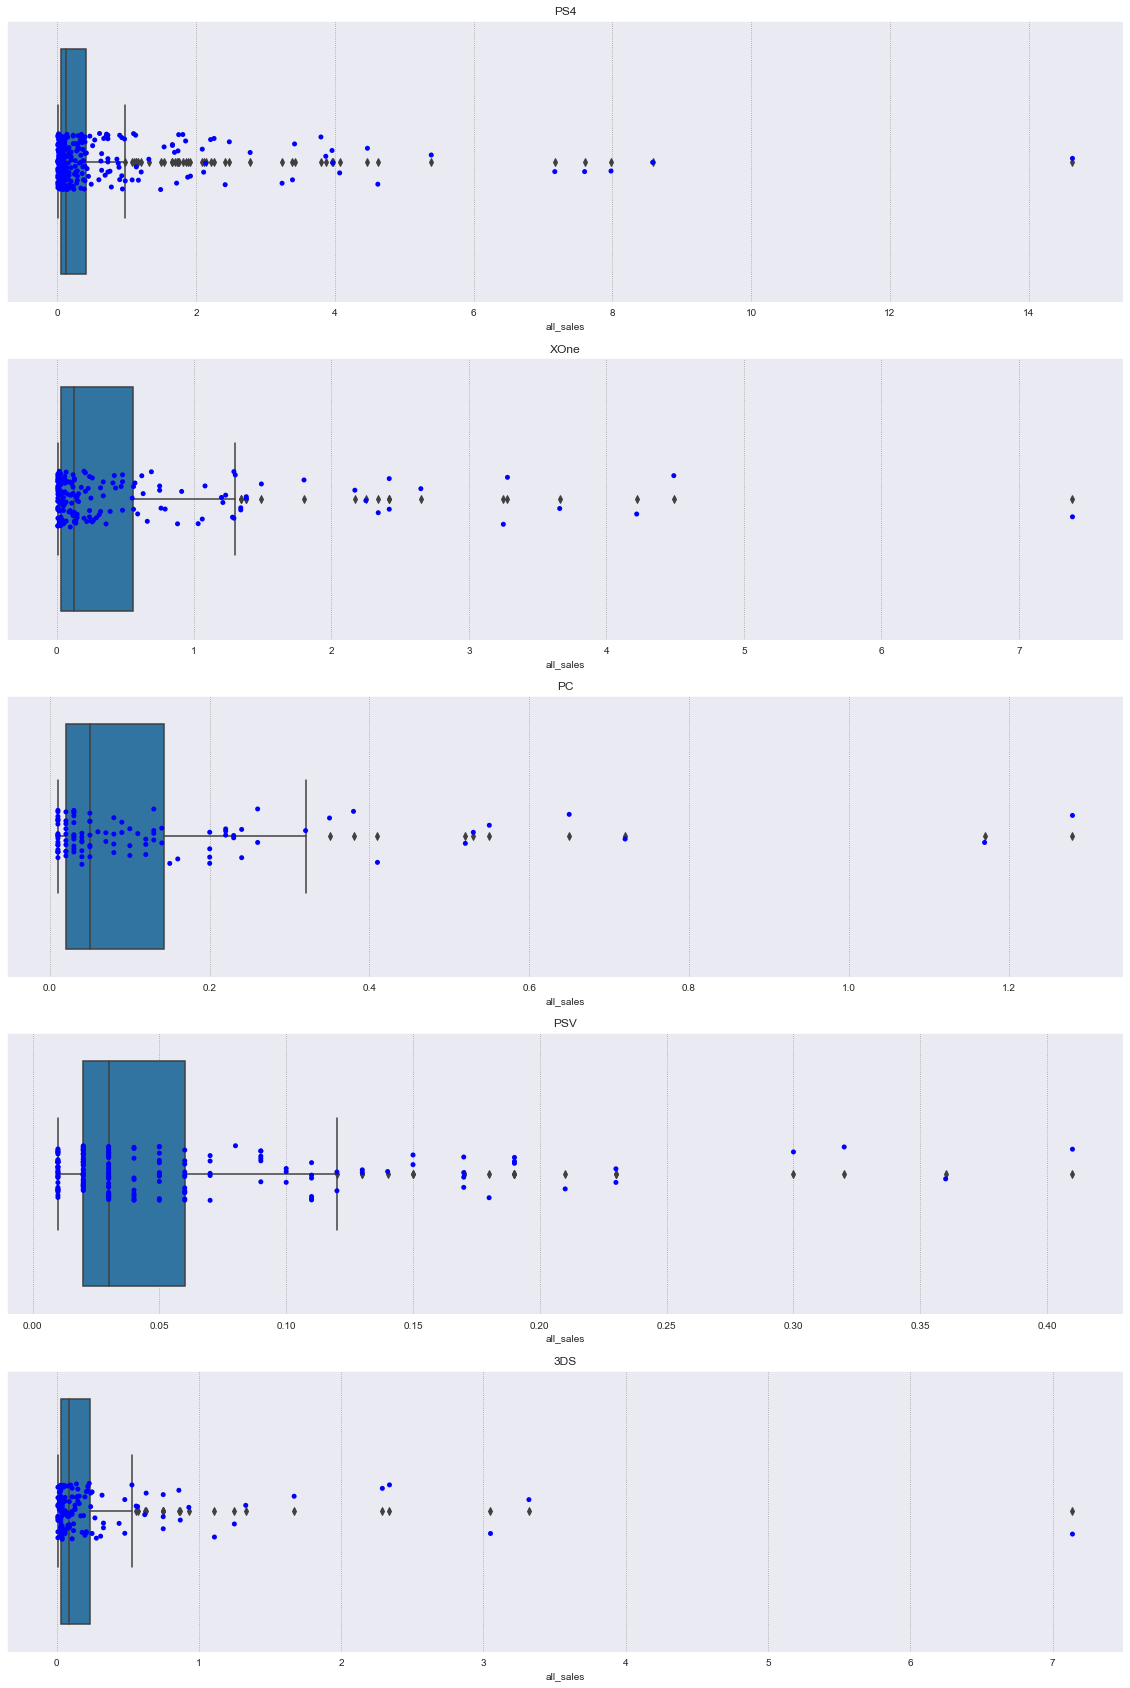

In [26]:
fig = plt.figure(figsize=(20,30))
plt.axis('off')

for i, p in enumerate(platforms):
    ax = fig.add_subplot(len(platforms), 1, i + 1)
    ax.set_title(p)
    sns.boxplot(x = df_new[df_new['platform'] == p]['all_sales'])
    sns.stripplot(x= df_new[df_new['platform'] == p]['all_sales'], color='blue')

        
plt.show()

В данных есть аномальные значения, они хорошо заметны у PS4, XOne и 3DS. Значит там есть игры, которые сильно выстреливают и их достаточно много, скорее всего это какие-то эксклюзивы. Вот у PC мы такой картины не видим. Вообще, насколько я знаю, цены на игры на консолях на порядок выше, чем на ПК, ну а самой прибыльной консолью кажется PS4 (ну она была действительно самая крутая, с кучей эксклюзивов, сейчас на дворе конец 2022, а она жива до сих пор, правда в Pro версии). Я выберу для дальнейшего анализа PS4.

## Отзывы и продажи PS4

Окей, выделим данные с PS4, благо их достаточно, так как она самая популярная. Уберем данные с пропущенными оценками при анализе, чтобы получить достоверные выводы.

In [27]:
df_ps = df_new[df_new['platform'] == 'PS4'].copy()
df_ps.shape

(301, 12)

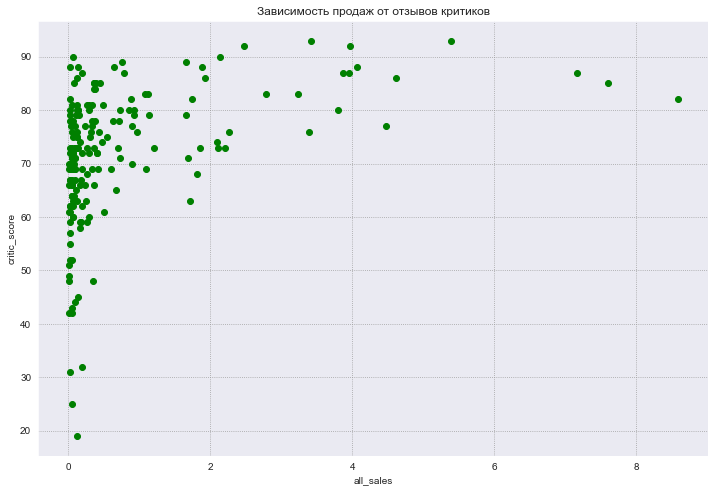

In [28]:
plt.figure(figsize=(12,8))
plt.title('Зависимость продаж от отзывов критиков')
plt.scatter(df_ps[df_ps['critic_score'] != -1]['all_sales'], df_ps[df_ps['critic_score'] != -1]['critic_score'], c='green')
plt.xlabel('all_sales')
plt.ylabel('critic_score')
plt.show()

In [29]:
df_ps['user_score'].unique()

array([-1., -2.], dtype=float32)

А вот как раз отзывы игроков на игры PS4 2015, 2016 года либо пропущены, либо TBD (сони что запретили оценивать игры???)

In [30]:
df_ps[df_ps['critic_score'] != -1][['critic_score', 'all_sales', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']]\
        .corr()[['critic_score']]

,critic_score
critic_score,1.000000
all_sales,0.392849
na_sales,0.406409
eu_sales,0.310625
jp_sales,0.366784
other_sales,0.394959


Итак, визуально на графике видно, что игры с хорошими оценками критиков лучше и больше продаются. Также видно, что между продажами и оценками критиков есть линейная зависимость (корреляция), причем они коррелируют довольно сильно. Такая же тенденция должна сохраняться для других платформ, так как это в целом логично. Однако, критики часто бывают куплены и на продажи также должны влиять оценки пользователей. По поводу отзывов пользователей, к сожалению, сказать ничего не получится. Хотя у меня появилась мысль, что TBD (-2) может появляться из-за того, что оценка этой игры пользователями есть где-то на другой платформе. Давайте попробуем это проверить и восстановить.

In [31]:
def fill_tbd(df):
    df_res = df.copy()
    new_scores = []
    for i in range(len(df_res)):
        if df_res.iloc[i]['user_score'] == -2:
            platform = df_res.iloc[i]['platform']
            game = df_res.iloc[i]['name']
            year = df_res.iloc[i]['year_of_release']
            scores = np.unique(df_res[(df_res['name'] == game) & (df_res['year_of_release'] == year) &\
                                      (df_res['platform'] != platform)]['user_score'].values)
            scores = np.concatenate((scores, [-1]), axis=0)
            new_scores.append(np.max(scores))
        else:
            new_scores.append(df_res.iloc[i]['user_score'])
    df_res['user_score'] = new_scores
    return df_res

In [32]:
df_new1 = fill_tbd(df_new)

In [33]:
df_ps1 = df_new1[df_new1['platform'] == 'PS4'].copy()
df_ps1.shape

(301, 12)

In [34]:
df_ps1['user_score'].unique()

array([-1.])

Функцию написал, однако, восстановить не получилось, похоже, что для этих игр действительно такая ситуация

## Игры по жанрам

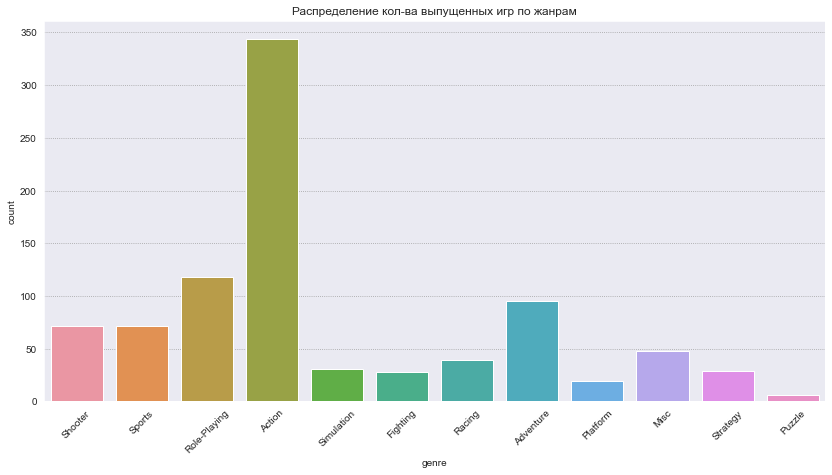

In [35]:
plt.figure(figsize=(14,7))
plt.title('Распределение кол-ва выпущенных игр по жанрам')
sns.countplot(df_new['genre'])
plt.xticks(rotation=45)
plt.show()

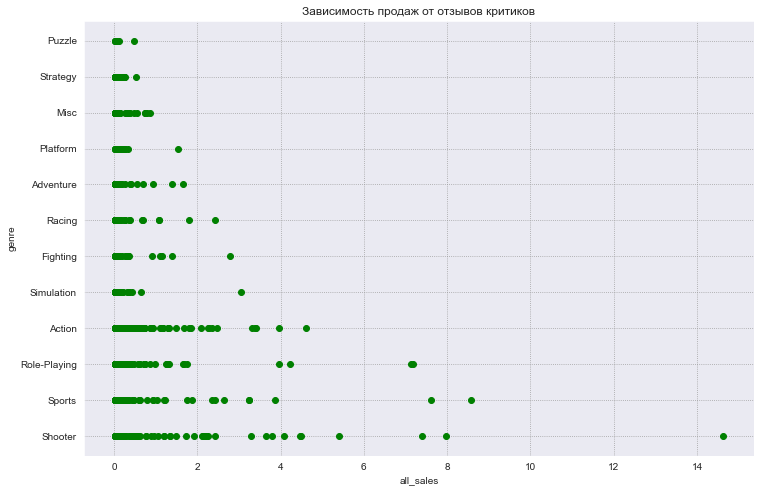

In [36]:
plt.figure(figsize=(12,8))
plt.title('Зависимость продаж от отзывов критиков')
plt.scatter(df_new['all_sales'], df_new['genre'], c='green')
plt.xlabel('all_sales')
plt.ylabel('genre')
plt.show()

Больше всего за 15-16 года по выбранным платформам выпускалось игр жанра Action, однако, самыми прибыльными можно отметить шутеры и спортивные игры (их вышло примерно одинаково), а также рол плеи (их чуть больше чем шутеров). Согласен со всем, кроме рол плеев, хотя были и очень популярные игры для консолей по типу кино, они соответственно и были прибыльными.

# Портрет пользователя

Не очень понимаю, как отдельно выделить регион, поэтому предлагаю просуммировать продажи в рамках каждой платформы, а затем в рамках жанра по регионам и посмотреть наиболее прибыльные (скорее всего это равно наиболее популярные)

## Платформы

In [37]:
df_new.groupby('platform').sum()[['na_sales', 'eu_sales', 'jp_sales']].reset_index()

,platform,na_sales,eu_sales,jp_sales
0,3DS,10.31,7.39,23.55
1,PC,3.72,9.10,0.00
2,PS4,63.86,83.54,12.05
3,PSV,0.54,1.08,8.41
4,XOne,50.30,28.10,0.18


In [38]:
df_new.groupby('platform').sum()[['na_sales', 'eu_sales', 'jp_sales']]\
    .transform(lambda x: x / x.sum() * 100, axis = 0).reset_index()

,platform,na_sales,eu_sales,jp_sales
0,3DS,8.009011,5.719372,53.292600
1,PC,2.889769,7.042799,0.000000
2,PS4,49.607706,64.654439,27.268613
3,PSV,0.419483,0.835849,19.031455
4,XOne,39.074031,21.747543,0.407332


* Для Северной Америки почти 50 процентов продаж приходит с PS4 и 40 с XOne. То есть в сумме для этого региона почти 90 процентов это консоли от Sony и Microsoft. Очень низкая доля PC - менее 3 процентов
* Для Европы PS4 уже 64.65 процента, при этом доля Xone значительно проседает (ну консоли Microsoft гораздо популярнее в США, это факт). Доля PC тоже низкая - 7 процентов
* В Японии на PC не играют, зато в топе 3DS - 53%. Странно, что PS4 от японской компании Sony так сильно проигрывает 3DS, доля PS4 27 %. Также тут играют в PSV, в которые практически не играют в США и Европе.


## Жанры

In [39]:
df_new.groupby('genre').sum()[['na_sales', 'eu_sales', 'jp_sales']].reset_index()

,genre,na_sales,eu_sales,jp_sales
0,Action,28.26,30.23,20.16
1,Adventure,2.81,3.83,1.99
2,Fighting,4.67,3.25,1.08
3,Misc,2.93,2.16,2.39
4,Platform,1.46,1.46,0.25
5,Puzzle,0.06,0.13,0.51
6,Racing,2.82,6.46,0.25
7,Role-Playing,19.07,16.66,12.10
8,Shooter,44.10,37.27,2.10
9,Simulation,1.03,3.43,1.93


In [40]:
df_new.groupby('genre').sum()[['na_sales', 'eu_sales', 'jp_sales']]\
    .transform(lambda x: x / x.sum() * 100, axis = 0).reset_index()

,genre,na_sales,eu_sales,jp_sales
0,Action,21.952925,23.396022,45.621181
1,Adventure,2.182863,2.964167,4.503281
2,Fighting,3.627748,2.515285,2.443992
3,Misc,2.276082,1.671697,5.408463
4,Platform,1.134157,1.129944,0.565739
5,Puzzle,0.046609,0.100611,1.154107
6,Racing,2.190632,4.999613,0.565739
7,Role-Playing,14.813952,12.893739,27.381761
8,Shooter,34.257749,28.844517,4.752206
9,Simulation,0.800124,2.654593,4.367504


* В Северной Америке Самые популярные жанры это Шутер, Экшн и Спорт, также в топе ролевые игры (Вспоминаем тот факт, что это одновременно самые прибыльные жанры)
* В Европе такая же ситуация 
* В Японии чуть больше любят Экшн и ролевые


## Влияние рейтинга ESRB

E - для всех (1), E10+ - для всех старше 10 (2), T - подросткам (3), M - для взрослых (4)

In [41]:
df_new['rating'].unique()

array(['M', 'E', 'T', 'E10+'], dtype=object)

In [42]:
map_dict = {
    'E' : 1,
    'E10+' : 2,
    'T' : 3,
    'M' : 4
}

df_new['rating_code'] = df_new['rating'].map(map_dict) 
df_new['rating_code'].unique()

array([4, 1, 3, 2], dtype=int64)

In [43]:
df_new[['rating_code', 'na_sales', 'eu_sales', 'jp_sales']]\
        .corr()[['rating_code']]

,rating_code
rating_code,1.000000
na_sales,0.163027
eu_sales,0.098567
jp_sales,0.037257


По корреляции больше всего рейтинг влияет на продажи в NA регоине 

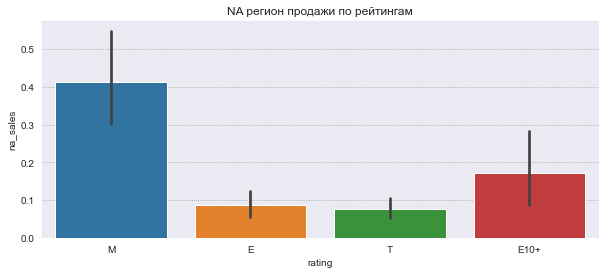

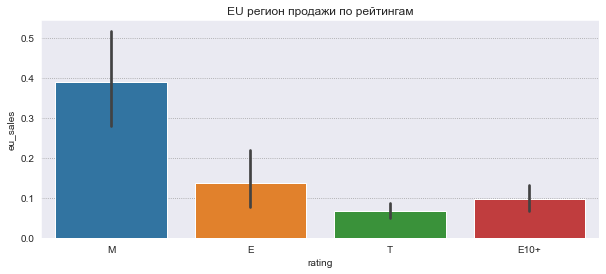

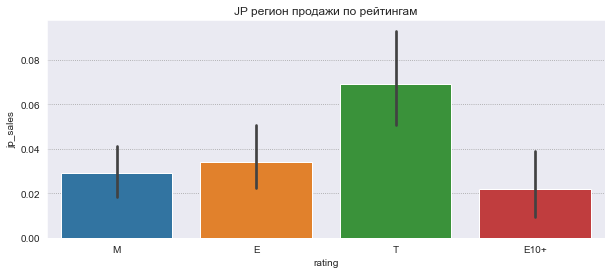

In [47]:
plt.figure(figsize=(10,4))
plt.title('NA регион продажи по рейтингам')
sns.barplot(y=df_new['na_sales'], x=df_new['rating'])

plt.figure(figsize=(10,4))
plt.title('EU регион продажи по рейтингам')
sns.barplot(y=df_new['eu_sales'], x=df_new['rating'])

plt.figure(figsize=(10,4))
plt.title('JP регион продажи по рейтингам')
sns.barplot(y=df_new['jp_sales'], x=df_new['rating'])

plt.show()

В Америке и Европе больше всего продаются игры с рейтингом для взрослых. В Японии для подростков. В США и Европе игры для подростков наименее популярны.

# Гипотезы о равенстве средних

## Средние рейтинги платформ Xbox One и PC одинаковые

Так как я не придумал, как правильно заполнить пропуски и все значения пользовательских оценок для этих платформ -1 и -2, будем проверять для оценок критиков

Для данной задачи используем t тест Стьюданта о равенстве средних для независимых выборок. H0: средние двух выборок одинаковы, HA: средние отличаются.

Вообще в идеале проверить гипотезу о сдвиге (H0: средние двух выборок отличаются),  но реализации я не нашел


In [52]:
sample1 = df_new[(df_new['platform'] == 'XOne') & (df_new['critic_score'] != -1)]['critic_score'].values
sample2 = df_new[(df_new['platform'] == 'PC') & (df_new['critic_score'] != -1)]['critic_score'].values

In [53]:
from scipy.stats import ttest_ind 

alpha = 0.05

results = ttest_ind(
    sample1, 
    sample1,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


H0 не отвергается, это не говорит нам о равенстве средних, скорее говорит о том, что различие средних не статистически значимо 

## Средние пользовательские рейтинги жанров Action и Sports разные

Также сделаем T-test. H0: средние двух выборок одинаковы, HA: средние отличаются.

In [59]:
sample1 = df_new[(df_new['genre'] == 'Action') & (df_new['critic_score'] != -1)]['critic_score'].values
sample2 = df_new[(df_new['genre'] == 'Sports') & (df_new['critic_score'] != -1)]['critic_score'].values

In [61]:
from scipy.stats import ttest_ind 

alpha = 0.05

results = ttest_ind(
    sample1, 
    sample1,
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


Аналогично H0 не отвергается, это не говорит о том, что средние точно не отличаются, скорее говорит о том, что различие средних не статистически значимо 

# Выводы

Основные выводы я писал по ходу работы, кратко:

* Столкнулся с проблемой заполнения пользовательских оценок, попытки ее решить не привели к успеху, больше идей не было
* Наиболее прибыльные платформы за последнее время это консоли PS4 и XboxOne, жанры Экшен, Шутер, Спорт, Ролевые. Я бы тратил деньги на рекламные проекты таких продуктов.
* Рынок США и Европы очень похожий, для них можно использовать одну стратегию с небольшими уточнениями, больше всего ценятся игры с рейтингом для взрослых. Для Японии нужна другая стратегия как по девайсам, так и по жанрам и рейтингам
